In [1]:
n_scenario = 16
budget_vector = [0,10,20,30,40,50,60,70,80]
num_scenario = '/' + str(n_scenario) + '_Scenario/'

import os
import sys
import yaml
import json
import warnings
import numpy as np
import pandas as pd
import gurobipy as gp
from tqdm import tqdm
from IPython import embed
import matplotlib.pyplot as plt
from tqdm.contrib import itertools

pd.set_option('display.max_rows', None)
sys.path.append("/Users/ashutoshshukla/Desktop/TwoStageModel/")

from utils import prepare_input
from main_model import two_stage_model

pd.options.display.max_seq_items = 200
pd.set_option('display.width', 100)
pd.set_option('display.max_rows', 40)
pd.set_option('display.max_columns', 50)
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
with open(r'../config.yaml') as file:
    model_params = yaml.load(file, Loader=yaml.FullLoader)

model_params["path_to_input"] = '/Users/ashutoshshukla/Desktop/Data/fixed_reduced_grid' + num_scenario
model_params["input1"], model_params["input2"] = prepare_input(model_params["path_to_input"])

print("MIP-Gap: ", model_params["mip_gap"])
print("Time Limit: ", model_params["time_limit"])
print("Robust Model: ", model_params["robust_flag"])
print("Flexible Generation: ", model_params["flexible_generation"])
print("Objective Type:\t", model_params["set_objective"], "\n")
print("Solver Method:\t", model_params["solver_method"], "\n")

flood_df = model_params["input1"].iloc[:,9:].copy()
flood_df_columns = flood_df.columns
input1_copy = model_params["input1"].drop(flood_df_columns, axis=1).copy()

MIP-Gap:  0.005
Time Limit:  21600
Robust Model:  False
Flexible Generation:  True
Objective Type:	 min 

Solver Method:	 2 



In [3]:
model_params["time_limit"] = 21600

### Wait and see bound calculation

In [4]:
# wait_and_see_dict = {}

# for budget in budget_vector:
#     wait_and_see_dict[budget] = {}

# for budget, scenario in itertools.product(budget_vector, flood_df_columns):
#     model_params["input1"] = input1_copy.copy()
#     model_params["input1"][scenario] = flood_df[scenario]
#     base_model = two_stage_model(model_params)
#     base_model.model.setParam("LogToConsole", 0)
#     base_model.budget_ref.rhs = budget*1e6
#     base_model.model.setParam("MIPGap", model_params["mip_gap"])
#     base_model.model.setParam("TimeLimit", model_params["time_limit"])
#     base_model.model.setParam("Method", model_params["solver_method"])
#     base_model.model.optimize()
#     wait_and_see_dict[budget][scenario] = base_model.model.objVal

# json_object = json.dumps(wait_and_see_dict, indent=4)

# with open("wait_and_see_dict.json", "w") as outfile:
#     outfile.write(json_object)

with open('wait_and_see_dict.json', 'r') as openfile:
    wait_and_see_dict = json.load(openfile)

In [5]:
wait_and_see_bound = {}
for i in wait_and_see_dict:
    temp = 0
    for j in wait_and_see_dict[i]:
        temp = temp + wait_and_see_dict[i][j]
    temp = temp/len(wait_and_see_dict[i])
    wait_and_see_bound[i] = temp

### Mean value solution bound

In [6]:
mean_solution = {}

for budget in budget_vector:
    mean_solution[budget] = {}

for budget in tqdm(budget_vector):    
    model_params["input1"] = input1_copy.copy()
    model_params["input1"]["max_mean_value_solution"] = np.ceil(flood_df.mean(axis=1))
    base_model = two_stage_model(model_params)
    base_model.model.setParam("LogToConsole", 0)
    base_model.budget_ref.rhs = budget*1e6
    base_model.model.setParam("MIPGap", model_params["mip_gap"])
    base_model.model.setParam("TimeLimit", model_params["time_limit"])
    base_model.model.setParam("Method", model_params["solver_method"])
    base_model.model.optimize()
    print("Final solution on mean value scenario:\t", base_model.model.objVal)
    for substation in base_model.x:
        mean_solution[budget][substation] = base_model.x[substation].X

 11%|█████                                        | 1/9 [00:00<00:07,  1.08it/s]

Final solution on mean value scenario:	 59.30672685264403


 22%|██████████                                   | 2/9 [00:09<00:39,  5.68s/it]

Final solution on mean value scenario:	 17.197862982814968


 33%|███████████████                              | 3/9 [00:16<00:35,  6.00s/it]

Final solution on mean value scenario:	 7.537989999999752


 44%|████████████████████                         | 4/9 [00:24<00:34,  6.88s/it]

Final solution on mean value scenario:	 3.414849999999717


 56%|█████████████████████████                    | 5/9 [00:28<00:22,  5.67s/it]

Final solution on mean value scenario:	 0.9940498459087053


 67%|██████████████████████████████               | 6/9 [00:29<00:13,  4.37s/it]

Final solution on mean value scenario:	 0.0208199999997305


 78%|███████████████████████████████████          | 7/9 [00:32<00:07,  3.63s/it]

Final solution on mean value scenario:	 -3.410605131648481e-13


 89%|████████████████████████████████████████     | 8/9 [00:34<00:03,  3.15s/it]

Final solution on mean value scenario:	 -3.410605131648481e-13


100%|█████████████████████████████████████████████| 9/9 [00:36<00:00,  4.02s/it]

Final solution on mean value scenario:	 -3.410605131648481e-13


### Strategy evaluation for mean value solution

In [7]:
mean_value_bound = {}

model_params["input1"], model_params["input2"] = prepare_input(model_params["path_to_input"])
base_model = two_stage_model(model_params)

for budget in tqdm(budget_vector):
    base_model.budget_ref.rhs = budget*1e6
    temp_constraint =  base_model.model.addConstrs((base_model.x[i] == round(mean_solution[budget][i]) 
                                                   for i in mean_solution[budget]))
    base_model.model.setParam("LogToConsole", 0)
    base_model.model.setParam("MIPGap", model_params["mip_gap"])
    base_model.model.setParam("TimeLimit", model_params["time_limit"])
    base_model.model.setParam("Method", model_params["solver_method"])
    base_model.model.optimize()
    mean_value_bound[budget] = base_model.model.objVal
    base_model.model.remove(temp_constraint)

100%|█████████████████████████████████████████████| 9/9 [00:19<00:00,  2.20s/it]


### Stochastic Solution

In [8]:
df = pd.read_csv(os.path.dirname(os.getcwd()) + "/output/sm_" + str(n_scenario) + "/stochastic_solution.csv")
stochastic_solution = {}

for i in range(df.shape[0]):
    stochastic_solution[df.iloc[i,0]] = df.iloc[i,1]

## robust solution

In [9]:
df_r = pd.read_csv(os.path.dirname(os.getcwd()) + "/output/rm_" + str(n_scenario) + "/robust_solution.csv")
robust_solution = {}

for i in range(df_r.shape[0]):
    robust_solution[df_r.iloc[i,0]] = df_r.iloc[i,1]

In [10]:
robust_solution

{0: 56.03,
 10: 25.81,
 20: 15.7,
 30: 9.91,
 40: 5.25,
 50: 2.53,
 60: 0.61,
 70: 0.02,
 80: 0.0}

In [11]:
wait_and_see_bound

{'0': 44.630551457775354,
 '10': 13.629312844488016,
 '20': 6.360349639926728,
 '30': 2.7672237499997117,
 '40': 0.9433318731221405,
 '50': 0.18526687498525618,
 '60': 0.007301249999656534,
 '70': -3.410605131648481e-13,
 '80': -3.410605131648481e-13}

In [12]:
mean_value_bound

{0: 44.6212503024675,
 10: 31.264485225767373,
 20: 26.404639287473913,
 30: 23.524099505665617,
 40: 22.01672661482303,
 50: 21.185329993069274,
 60: 21.15596718955635,
 70: 21.15596715915757,
 80: 21.15596715915757}

In [13]:
stochastic_solution

{0: 44.62,
 10: 22.2,
 20: 13.74,
 30: 8.3,
 40: 4.79,
 50: 2.35,
 60: 0.6,
 70: 0.02,
 80: 0.0}

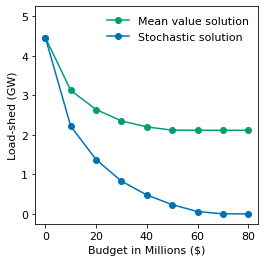

In [18]:
#plt.rcParams['text.usetex'] = True

load = model_params["input1"]["load"].sum()


ss = [x/10 for x in list(stochastic_solution.values())]
mvs = [x/10 for x in list(mean_value_bound.values())]
was = [x/10 for x in list(wait_and_see_bound.values())]
#rs = [x/10 for x in list(robust_solution.values())]

plt.figure(figsize=(4,4))
plt.plot(budget_vector, mvs, marker='o', label = "Mean value solution", color="#009e73")
plt.plot(budget_vector, ss, marker='o', label = "Stochastic solution", color="#0072b2")
#plt.plot(budget_vector, was, marker='o', label = "Wait-and-see solution", color="#d55e00")

#plt.plot(budget_vector, rs, marker='o', label = "robust solution")

#plt.set_xticklabels([0,10,20,30,40,50,60,70,71.35])

plt.xlabel("Budget in Millions ($)", fontdict={'fontsize': 11})
plt.ylabel("Load-shed (GW)", fontdict={'fontsize': 11})
plt.legend(loc=1, prop={'size': 11}, frameon=False)
plt.ylim(-0.25,5.25)

plt.xticks(fontsize=11, rotation=0)
plt.yticks(fontsize=11, rotation=0)

#plt.savefig(os.path.dirname(os.getcwd()) + "/output/sm_" + str(n_scenario) + "/bounds.eps", format='eps')

plt.savefig("/Users/ashutoshshukla/Desktop/bounds.eps", format='eps')

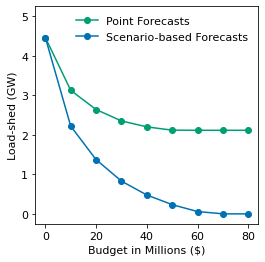

In [21]:
#plt.rcParams['text.usetex'] = True

load = model_params["input1"]["load"].sum()


ss = [x/10 for x in list(stochastic_solution.values())]
mvs = [x/10 for x in list(mean_value_bound.values())]
was = [x/10 for x in list(wait_and_see_bound.values())]
#rs = [x/10 for x in list(robust_solution.values())]

plt.figure(figsize=(4,4))
plt.plot(budget_vector, mvs, marker='o', label = "Point Forecasts", color="#009e73")
plt.plot(budget_vector, ss, marker='o', label = "Scenario-based Forecasts", color="#0072b2")
#plt.plot(budget_vector, was, marker='o', label = "Wait-and-see solution", color="#d55e00")

#plt.plot(budget_vector, rs, marker='o', label = "robust solution")

#plt.set_xticklabels([0,10,20,30,40,50,60,70,71.35])

plt.xlabel("Budget in Millions ($)", fontdict={'fontsize': 11})
plt.ylabel("Load-shed (GW)", fontdict={'fontsize': 11})
plt.legend(loc=1, prop={'size': 11}, frameon=False)
plt.ylim(-0.25,5.25)

plt.xticks(fontsize=11, rotation=0)
plt.yticks(fontsize=11, rotation=0)

#plt.savefig(os.path.dirname(os.getcwd()) + "/output/sm_" + str(n_scenario) + "/bounds.eps", format='eps')

plt.savefig("/Users/ashutoshshukla/Desktop/bounds.eps", format='eps')

In [ ]:
plt.figure(figsize=(6,6))
plt.plot(budget_vector, ss, marker='o', label = "stochastic solution", color="blue")
plt.plot(budget_vector, rs, marker='o', label = "robust solution", color="k")

plt.xlabel("Budget in Millions", fontdict={'fontsize': 16})
plt.ylabel("Load-shed in Gw-hr", fontdict={'fontsize': 16})
plt.legend(loc=1, prop={'size': 14})
#plt.savefig(os.path.dirname(os.getcwd()) + "/output/sm_" + str(n_scenario) + "/robust_bounds.eps", format='eps')